# Homework 2. Training networks in PyTorch

Это домашнее задание посвящено отработки навыков по написанию и обучению нейронных сетей. Ваше задание реализовать обучение нейронной сети и выполнить задания по анализу сети в конце ноутбука. Удачи!

<font color='red'> **Дедлайн 4 октября 23:59 (жесткий)**  </font>

### Data loading in pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

You will works with a MNIST dataset. It contains grayscale images of handwritten digits of size 28 x 28. The number of training objects is 60000.


In pytorch, there is a special module to download MNIST. But for us it is more convinient to load the data ourselves.

In [3]:
from util import load_mnist

In [4]:
X_train, y_train, X_test, y_test = load_mnist()

The code below prepares short data (train and val) for seminar purposes (use this data to quickly learn model on CPU and to tune the hyperparameters). Also, we prepare the full data (train_full and test) to train a final model.

In [5]:
# shuffle data
np.random.seed(0)
idxs = np.random.permutation(np.arange(X_train.shape[0]))
X_train, y_train = X_train[idxs], y_train[idxs]

X_train.shape

(60000, 1, 28, 28)

Pytorch offers convinient class DataLoader for mini batch generation. You should pass instance of Tensor Dataset to it.

In [6]:
def get_loader(X, y, batch_size=64):
    train = torch.utils.data.TensorDataset(torch.from_numpy(X).float(),
                                       torch.from_numpy(y).long())
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size)
    return train_loader

# for final model:
train_loader_full = get_loader(X_train, y_train)
test_loader = get_loader(X_test, y_test)
# for validation purposes:
train_loader = get_loader(X_train[:15000], y_train[:15000])
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000])

C:\Users\sasha\AppData\Local\Temp\ipykernel_38624\2761436466.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  torch.from_numpy(y).long())


In [7]:
# check number of objects
val_loader.dataset.tensors[0].shape

torch.Size([15000, 1, 28, 28])

### Building LeNet-5

Convolutional layer (from Anton Osokin's presentation):
![slide](https://github.com/nadiinchi/dl_labs/raw/master/convolution.png)

You need to implement Lenet-5:

![Архитектура LeNet-5](https://www.researchgate.net/profile/Vladimir_Golovko3/publication/313808170/figure/fig3/AS:552880910618630@1508828489678/Architecture-of-LeNet-5.png)

Construct a network according to the image and code examples given above. Use ReLU nonlinearity (after all linear and convolutional layers). The network must support multiplying the number of convolutions in each convolutional layer by k.

Please note that on the scheme the size of the image is 32 x 32 but in our code the size is 28 x 28.

Do not apply softmax at the end of the forward pass!

### <font color='red'>[TODO] Написание архитектуры Le-Net-5 </font>

В этой части вам нужно реализовать архитектуру Le-Net-5, но учтите, что на вход изображения приходит 28x28.

Для того, написать архитектуру используйте [nn.Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [nn.AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html), [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html). Ориентируйтесь на картинку сверху в реализации

In [8]:
k = 1
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__( )
        ### your code here: define layers
        #First convolution layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6 * k, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        #Second convolution layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6 * k, out_channels=16 * k, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        #First linear layer
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=4 * 4 * 16 * k, out_features=120),
            nn.ReLU()
        )
        #Second linear layer
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU()
        )
        #Gauss layer
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=84, out_features=10)
        )
    def forward(self, x):
        conv1_output = self.conv1(x)  
        conv2_output = self.conv2(conv1_output)  
        conv2_output = conv2_output.view(-1, 4*4*16*k) #fast reshape 
        fc1_output = self.fc1(conv2_output)
        fc2_output = self.fc2(fc1_output)
        fc3_output = self.fc3(fc2_output)
        return fc3_output
        ### your code here: transform x using layers


Let's count the number of the parameters in the network:

In [9]:
cnn = CNN()

In [10]:
def count_parameters(model):
    return sum(param.data.numpy().size for param \
               in model.parameters() if param.requires_grad)

count_parameters(cnn)

44426

### Training

Let's define the loss function:

In [11]:
criterion = nn.CrossEntropyLoss() # loss includes softmax

Also, define a device where to store the data and the model (cpu or gpu):

In [12]:
print(torch.cuda.is_available())

False


In [14]:
device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU
cnn = cnn.to(device)

During training, we will control the quality on the training and validation set. This produces duplicates of the code. That's why we will define a function evaluate_loss_acc to evaluate our model on different data sets. In the same manner, we define function train_epoch to perform one training epoch on traiing data. Please note that we will compute the training loss _after_ each epoch (not averaging it during epoch).

In the propotypes, train and eval modes are noted. In our case, we don't need them (because we don't use neither dropout nor batch normalization). However, we will switch the regime so you can use this code in the future.

### <font color='red'>[TODO] Реализуйте функции обучение модели </font>

В части вам нужно написать циклы обучения моделей, вы можете ориентировать на ноутбук семинара при их выполнении

In [15]:
def train_epoch(model, optimizer, train_loader, criterion, device):
    """
    for each batch
    performs forward and backward pass and parameters update

    Input:
    model: instance of model (example defined above)
    optimizer: instance of optimizer (defined above)
    train_loader: instance of DataLoader

    Returns:
    nothing

    Do not forget to set net to train mode!
    """
    
    ### your code here
    model.train()
    for data_inputs, data_labels in train_loader:
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)
        
        prediction = model.forward(data_inputs)
        loss = criterion(prediction, data_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def evaluate_loss_acc(loader, model, criterion, device):
    """
    Evaluates loss and accuracy on the whole dataset

    Input:
    loader:  instance of DataLoader
    model: instance of model (examle defined above)

    Returns:
    (loss, accuracy)

    Do not forget to set net to eval mode!
    """
    model.eval()
    data_inputs, data_labels = next(iter(loader))
    prediction = model.forward(data_inputs)
    loss = criterion(prediction, data_labels)
    
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model.forward(data_inputs)
            pred_labels = np.argmax(model(data_inputs), axis=1) 
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    
    return loss, acc
    ### your code here


def train(model, opt, train_loader, test_loader, criterion, n_epochs,
          device, verbose=True):
    """
    Performs training of the model and prints progress

    Input:
    model: instance of model (example defined above)
    opt: instance of optimizer
    train_loader: instance of DataLoader
    test_loader: instance of DataLoader (for evaluation)
    n_epochs: int

    Returns:
    4 lists: train_log, train_acc_log, val_log, val_acc_log
    with corresponding metrics per epoch
    """
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_epoch(model, opt, train_loader, criterion, device)
        train_loss, train_acc = evaluate_loss_acc(train_loader,
                                                  model, criterion,
                                                  device)
        val_loss, val_acc = evaluate_loss_acc(test_loader, model,
                                              criterion, device)

        train_log.append(train_loss)
        train_acc_log.append(train_acc)

        val_log.append(val_loss)
        val_acc_log.append(val_acc)

        if verbose:
             print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,'+\
               ' Acc (train/test): %.4f/%.4f' )
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss, train_acc, val_acc))

    return train_log, train_acc_log, val_log, val_acc_log

### <font color='red'>[TODO] Обучение модели </font>

Train the neural network, using defined functions. Use Adam as an optimizer, learning_rate=0.001, number of epochs = 20. For hold out, use val_loader, not test_loader.

In [16]:
### your code here
n_epochs = 20
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
cnn.to(device)
train(cnn, optimizer, train_loader, test_loader, criterion, n_epochs, device)

Epoch [1/20], Loss (train/test): 0.3448/0.2582, Acc (train/test): 0.8978/0.9015
Epoch [2/20], Loss (train/test): 0.2207/0.1345, Acc (train/test): 0.9322/0.9305
Epoch [3/20], Loss (train/test): 0.1177/0.0795, Acc (train/test): 0.9529/0.9518
Epoch [4/20], Loss (train/test): 0.0671/0.0544, Acc (train/test): 0.9643/0.9623
Epoch [5/20], Loss (train/test): 0.0396/0.0493, Acc (train/test): 0.9699/0.9684
Epoch [6/20], Loss (train/test): 0.0309/0.0485, Acc (train/test): 0.9751/0.9696
Epoch [7/20], Loss (train/test): 0.0252/0.0567, Acc (train/test): 0.9777/0.9728
Epoch [8/20], Loss (train/test): 0.0190/0.0676, Acc (train/test): 0.9807/0.9743
Epoch [9/20], Loss (train/test): 0.0182/0.0815, Acc (train/test): 0.9802/0.9747
Epoch [10/20], Loss (train/test): 0.0149/0.0880, Acc (train/test): 0.9837/0.9776
Epoch [11/20], Loss (train/test): 0.0116/0.0891, Acc (train/test): 0.9854/0.9777
Epoch [12/20], Loss (train/test): 0.0114/0.0907, Acc (train/test): 0.9865/0.9776
Epoch [13/20], Loss (train/test): 0.0

([tensor(0.3448, grad_fn=<NllLossBackward0>),
  tensor(0.2207, grad_fn=<NllLossBackward0>),
  tensor(0.1177, grad_fn=<NllLossBackward0>),
  tensor(0.0671, grad_fn=<NllLossBackward0>),
  tensor(0.0396, grad_fn=<NllLossBackward0>),
  tensor(0.0309, grad_fn=<NllLossBackward0>),
  tensor(0.0252, grad_fn=<NllLossBackward0>),
  tensor(0.0190, grad_fn=<NllLossBackward0>),
  tensor(0.0182, grad_fn=<NllLossBackward0>),
  tensor(0.0149, grad_fn=<NllLossBackward0>),
  tensor(0.0116, grad_fn=<NllLossBackward0>),
  tensor(0.0114, grad_fn=<NllLossBackward0>),
  tensor(0.0079, grad_fn=<NllLossBackward0>),
  tensor(0.0075, grad_fn=<NllLossBackward0>),
  tensor(0.0091, grad_fn=<NllLossBackward0>),
  tensor(0.0161, grad_fn=<NllLossBackward0>),
  tensor(0.0134, grad_fn=<NllLossBackward0>),
  tensor(0.0050, grad_fn=<NllLossBackward0>),
  tensor(0.0034, grad_fn=<NllLossBackward0>),
  tensor(0.0084, grad_fn=<NllLossBackward0>)],
 [tensor(0.8978),
  tensor(0.9322),
  tensor(0.9529),
  tensor(0.9643),
  tenso

### <font color='red'>[TODO] Проведите эксперименты с моделью </font>


### Choosing  learning_rate and batch_size

Plot accuracy on the training and testing set v. s. training epoch for different learning parameters: learning rate$ \in \{0.0001, 0.001, 0.01\}$, batch size $\in \{64, 256\}$.

The best option is to plot training curves on the left graph and validation curves on the right graph with the shared y axis (use plt.ylim).

How do learning rate and batch size affect the final quality of the model?

In [17]:
n_epochs = 20
lr_list = [0.0001, 0.001, 0.01]
batch_size_list = [24, 256]
ans = []
for bs in batch_size_list:
    ans_i = []
    train_loader_full = get_loader(X_train, y_train, bs)
    test_loader = get_loader(X_test, y_test, bs)
    # for validation purposes:
    train_loader = get_loader(X_train[:15000], y_train[:15000], bs)
    val_loader = get_loader(X_train[15000:30000], y_train[15000:30000], bs)
    for lri in lr_list:
        cnn = CNN()
        cnn = cnn.to(device)
        
        optimizer = torch.optim.Adam(cnn.parameters(), lr = lri)
        cnn.to(device)
        ans_i += [train(cnn, optimizer, train_loader, test_loader, criterion, n_epochs, device)]
    ans += [ans_i]

Epoch [1/20], Loss (train/test): 0.4080/0.6639, Acc (train/test): 0.8051/0.8095
Epoch [2/20], Loss (train/test): 0.1893/0.4859, Acc (train/test): 0.8542/0.8564
Epoch [3/20], Loss (train/test): 0.1376/0.3977, Acc (train/test): 0.8757/0.8777
Epoch [4/20], Loss (train/test): 0.1179/0.3373, Acc (train/test): 0.8893/0.8932
Epoch [5/20], Loss (train/test): 0.1059/0.2934, Acc (train/test): 0.9016/0.9045
Epoch [6/20], Loss (train/test): 0.1026/0.2518, Acc (train/test): 0.9109/0.9136
Epoch [7/20], Loss (train/test): 0.0997/0.2065, Acc (train/test): 0.9181/0.9196
Epoch [8/20], Loss (train/test): 0.0974/0.1799, Acc (train/test): 0.9233/0.9262
Epoch [9/20], Loss (train/test): 0.0941/0.1535, Acc (train/test): 0.9284/0.9315
Epoch [10/20], Loss (train/test): 0.0870/0.1299, Acc (train/test): 0.9321/0.9356
Epoch [11/20], Loss (train/test): 0.0825/0.1047, Acc (train/test): 0.9352/0.9395
Epoch [12/20], Loss (train/test): 0.0755/0.0879, Acc (train/test): 0.9398/0.9416
Epoch [13/20], Loss (train/test): 0.0

Epoch [3/20], Loss (train/test): 0.0760/0.0394, Acc (train/test): 0.9763/0.9747
Epoch [4/20], Loss (train/test): 0.0508/0.0403, Acc (train/test): 0.9830/0.9768
Epoch [5/20], Loss (train/test): 0.0568/0.0607, Acc (train/test): 0.9855/0.9773
Epoch [6/20], Loss (train/test): 0.0347/0.0368, Acc (train/test): 0.9881/0.9788
Epoch [7/20], Loss (train/test): 0.0177/0.0679, Acc (train/test): 0.9832/0.9703
Epoch [8/20], Loss (train/test): 0.0290/0.0417, Acc (train/test): 0.9867/0.9741
Epoch [9/20], Loss (train/test): 0.0181/0.0468, Acc (train/test): 0.9865/0.9717
Epoch [10/20], Loss (train/test): 0.0357/0.0828, Acc (train/test): 0.9761/0.9663
Epoch [11/20], Loss (train/test): 0.0239/0.0627, Acc (train/test): 0.9843/0.9748
Epoch [12/20], Loss (train/test): 0.0012/0.0214, Acc (train/test): 0.9947/0.9810
Epoch [13/20], Loss (train/test): 0.0051/0.0225, Acc (train/test): 0.9946/0.9806
Epoch [14/20], Loss (train/test): 0.0024/0.0218, Acc (train/test): 0.9952/0.9808
Epoch [15/20], Loss (train/test): 0

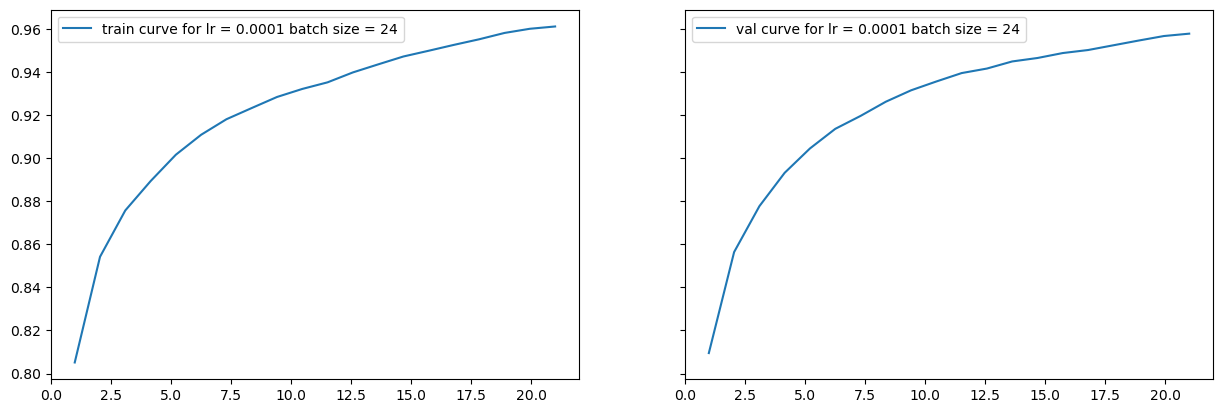

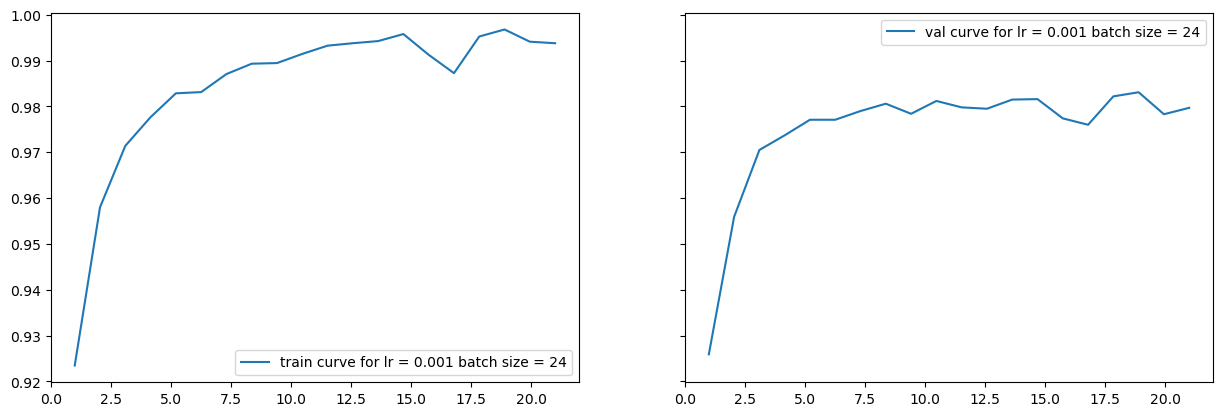

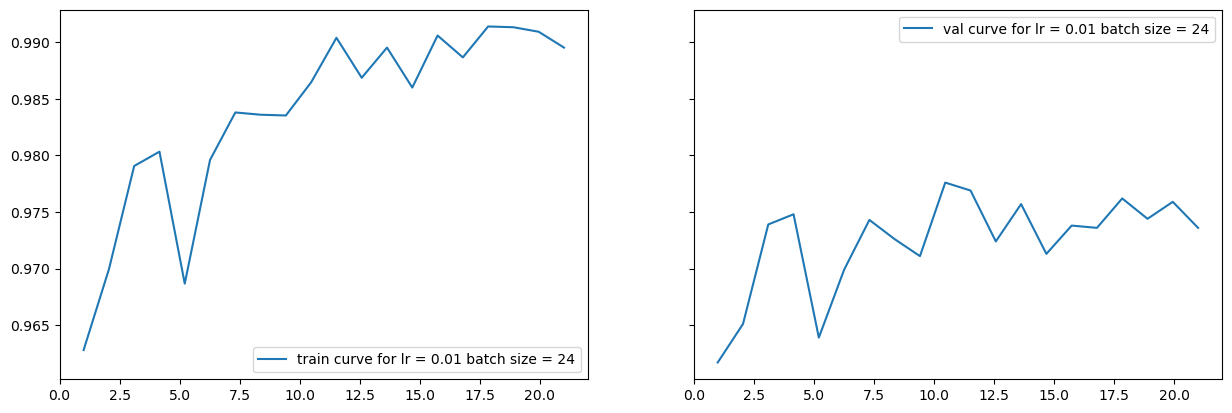

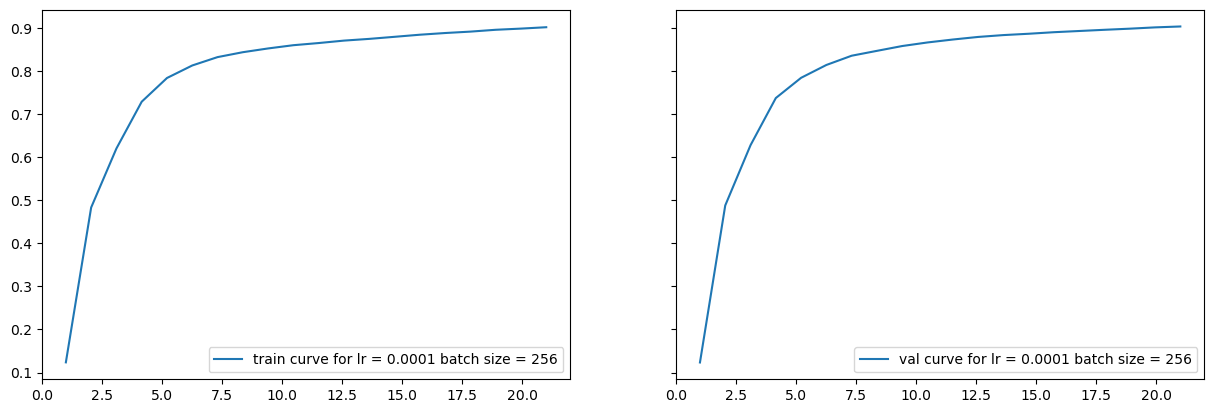

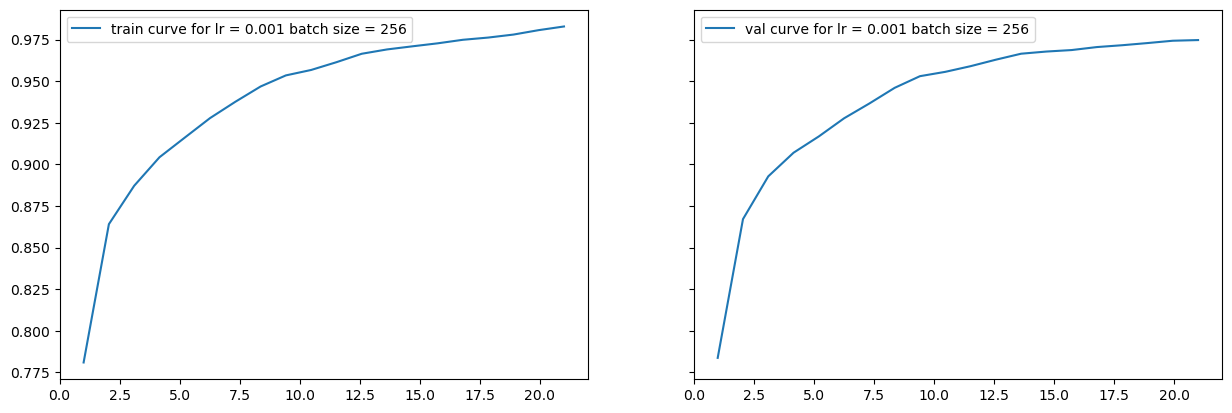

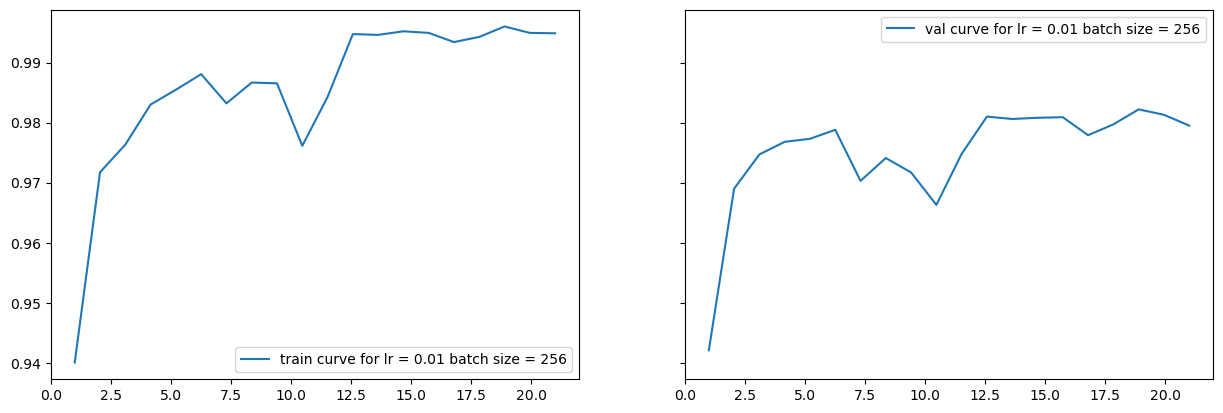

In [18]:

for i in range(0, len(batch_size_list)):
    for j in range(0,len(lr_list)):
        fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
        
        fig.set_figwidth(15) 
        x = np.linspace(1, n_epochs + 1, n_epochs)
        ax1.plot(x,ans[i][j][1], label = 'train curve for lr = ' + str(lr_list[j]) +' batch size = ' + str(batch_size_list[i]))
        
        ax1.legend()
        ax2.plot(x,ans[i][j][3], label = 'val curve for lr = ' + str(lr_list[j]) +' batch size = ' + str(batch_size_list[i]))
        ax2.legend()
        plt.show()
        

При увелечении lr оптимизатор начинает пропускать минимумы и сходится довольно неравномерно, также видно, что он начинает переобучаться. При увелечении batch_size эффект переобучения и нарушения сходимости наблюдается при большем значении lr, при этом функционал сходится быстрее, хотя на одну эпоху и требуется больше вычислений

### Changing the architecture

Try to modify our architecture: increase the number of filters and to reduce the number of fully-connected layers.

Insert numbers in the brackets:
* LeNet-5 classic (6 and 16 convolutions):  training acc: (0.9876)  validation acc: (0.9717)
* Number of convolutions x 4 (24 и 64 convolutions):  training acc: (0.9965)  validation acc: (0.9811)
* Removing fully connected layer: the previous network with 1 FC layer: training acc: ( 0.9916)  validation acc: (0.9812)
    
    

#### Classic 

In [19]:
k = 1
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__( )
        ### your code here: define layers
        #First convolution layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6 * k, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        #Second convolution layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6 * k, out_channels=16 * k, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        #First linear layer
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=4 * 4 * 16 * k, out_features=120),
            nn.ReLU()
        )
        #Second linear layer
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU()
        )
        #Gauss layer
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=84, out_features=10)
        )
    def forward(self, x):
        conv1_output = self.conv1(x)  
        conv2_output = self.conv2(conv1_output)  
        conv2_output = conv2_output.view(-1, 4*4*16*k) #fast reshape 
        fc1_output = self.fc1(conv2_output)
        fc2_output = self.fc2(fc1_output)
        fc3_output = self.fc3(fc2_output)
        return fc3_output
        ### your code here: transform x using layers


In [20]:
### your code here
cnn = CNN()
cnn = cnn.to(device)
n_epochs = 50
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
cnn.to(device)
train(cnn, optimizer, train_loader, test_loader, criterion, n_epochs, device)

Epoch [1/50], Loss (train/test): 0.6883/0.6878, Acc (train/test): 0.7711/0.7767
Epoch [2/50], Loss (train/test): 0.4384/0.4338, Acc (train/test): 0.8627/0.8639
Epoch [3/50], Loss (train/test): 0.3714/0.3527, Acc (train/test): 0.8846/0.8908
Epoch [4/50], Loss (train/test): 0.3040/0.2805, Acc (train/test): 0.9027/0.9064
Epoch [5/50], Loss (train/test): 0.2529/0.2256, Acc (train/test): 0.9153/0.9168
Epoch [6/50], Loss (train/test): 0.2166/0.1824, Acc (train/test): 0.9282/0.9308
Epoch [7/50], Loss (train/test): 0.1952/0.1550, Acc (train/test): 0.9333/0.9360
Epoch [8/50], Loss (train/test): 0.1671/0.1308, Acc (train/test): 0.9401/0.9436
Epoch [9/50], Loss (train/test): 0.1505/0.1106, Acc (train/test): 0.9467/0.9492
Epoch [10/50], Loss (train/test): 0.1313/0.0957, Acc (train/test): 0.9513/0.9522
Epoch [11/50], Loss (train/test): 0.1143/0.0817, Acc (train/test): 0.9562/0.9556
Epoch [12/50], Loss (train/test): 0.1092/0.0725, Acc (train/test): 0.9589/0.9576
Epoch [13/50], Loss (train/test): 0.1

([tensor(0.6883, grad_fn=<NllLossBackward0>),
  tensor(0.4384, grad_fn=<NllLossBackward0>),
  tensor(0.3714, grad_fn=<NllLossBackward0>),
  tensor(0.3040, grad_fn=<NllLossBackward0>),
  tensor(0.2529, grad_fn=<NllLossBackward0>),
  tensor(0.2166, grad_fn=<NllLossBackward0>),
  tensor(0.1952, grad_fn=<NllLossBackward0>),
  tensor(0.1671, grad_fn=<NllLossBackward0>),
  tensor(0.1505, grad_fn=<NllLossBackward0>),
  tensor(0.1313, grad_fn=<NllLossBackward0>),
  tensor(0.1143, grad_fn=<NllLossBackward0>),
  tensor(0.1092, grad_fn=<NllLossBackward0>),
  tensor(0.1037, grad_fn=<NllLossBackward0>),
  tensor(0.0927, grad_fn=<NllLossBackward0>),
  tensor(0.0900, grad_fn=<NllLossBackward0>),
  tensor(0.0864, grad_fn=<NllLossBackward0>),
  tensor(0.0814, grad_fn=<NllLossBackward0>),
  tensor(0.0759, grad_fn=<NllLossBackward0>),
  tensor(0.0716, grad_fn=<NllLossBackward0>),
  tensor(0.0682, grad_fn=<NllLossBackward0>),
  tensor(0.0645, grad_fn=<NllLossBackward0>),
  tensor(0.0628, grad_fn=<NllLossB

In [21]:
k = 4
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__( )
        ### your code here: define layers
        #First convolution layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6 * k, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        #Second convolution layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6 * k, out_channels=16 * k, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        #First linear layer
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=4 * 4 * 16 * k, out_features=120),
            nn.ReLU()
        )
        #Second linear layer
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU()
        )
        #Gauss layer
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=84, out_features=10)
        )
    def forward(self, x):
        conv1_output = self.conv1(x)  
        conv2_output = self.conv2(conv1_output)  
        conv2_output = conv2_output.view(-1, 4*4*16*k) #fast reshape 
        fc1_output = self.fc1(conv2_output)
        fc2_output = self.fc2(fc1_output)
        fc3_output = self.fc3(fc2_output)
        return fc3_output
        ### your code here: transform x using layers


In [22]:
### your code here
cnn = CNN()
cnn = cnn.to(device)
n_epochs = 50
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
cnn.to(device)
train(cnn, optimizer, train_loader, test_loader, criterion, n_epochs, device)

Epoch [1/50], Loss (train/test): 0.4328/0.4517, Acc (train/test): 0.8643/0.8681
Epoch [2/50], Loss (train/test): 0.2807/0.2670, Acc (train/test): 0.9103/0.9126
Epoch [3/50], Loss (train/test): 0.1906/0.1590, Acc (train/test): 0.9376/0.9374
Epoch [4/50], Loss (train/test): 0.1406/0.1032, Acc (train/test): 0.9546/0.9530
Epoch [5/50], Loss (train/test): 0.1126/0.0705, Acc (train/test): 0.9623/0.9618
Epoch [6/50], Loss (train/test): 0.0969/0.0602, Acc (train/test): 0.9677/0.9672
Epoch [7/50], Loss (train/test): 0.0804/0.0568, Acc (train/test): 0.9713/0.9693
Epoch [8/50], Loss (train/test): 0.0673/0.0584, Acc (train/test): 0.9738/0.9693
Epoch [9/50], Loss (train/test): 0.0545/0.0450, Acc (train/test): 0.9801/0.9762
Epoch [10/50], Loss (train/test): 0.0396/0.0397, Acc (train/test): 0.9833/0.9793
Epoch [11/50], Loss (train/test): 0.0340/0.0384, Acc (train/test): 0.9843/0.9782
Epoch [12/50], Loss (train/test): 0.0306/0.0405, Acc (train/test): 0.9834/0.9778
Epoch [13/50], Loss (train/test): 0.0

([tensor(0.4328, grad_fn=<NllLossBackward0>),
  tensor(0.2807, grad_fn=<NllLossBackward0>),
  tensor(0.1906, grad_fn=<NllLossBackward0>),
  tensor(0.1406, grad_fn=<NllLossBackward0>),
  tensor(0.1126, grad_fn=<NllLossBackward0>),
  tensor(0.0969, grad_fn=<NllLossBackward0>),
  tensor(0.0804, grad_fn=<NllLossBackward0>),
  tensor(0.0673, grad_fn=<NllLossBackward0>),
  tensor(0.0545, grad_fn=<NllLossBackward0>),
  tensor(0.0396, grad_fn=<NllLossBackward0>),
  tensor(0.0340, grad_fn=<NllLossBackward0>),
  tensor(0.0306, grad_fn=<NllLossBackward0>),
  tensor(0.0270, grad_fn=<NllLossBackward0>),
  tensor(0.0195, grad_fn=<NllLossBackward0>),
  tensor(0.0188, grad_fn=<NllLossBackward0>),
  tensor(0.0197, grad_fn=<NllLossBackward0>),
  tensor(0.0227, grad_fn=<NllLossBackward0>),
  tensor(0.0237, grad_fn=<NllLossBackward0>),
  tensor(0.0388, grad_fn=<NllLossBackward0>),
  tensor(0.0119, grad_fn=<NllLossBackward0>),
  tensor(0.0067, grad_fn=<NllLossBackward0>),
  tensor(0.0115, grad_fn=<NllLossB

In [25]:
k = 1
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__( )
        ### your code here: define layers
        #First convolution layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6 * k, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        #Second convolution layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6 * k, out_channels=16 * k, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        #First linear layer
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=4 * 4 * 16 * k, out_features=84),
            nn.ReLU()
        )
        #Gauss layer
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=84, out_features=10)
        )
    def forward(self, x):
        conv1_output = self.conv1(x)  
        conv2_output = self.conv2(conv1_output)  
        conv2_output = conv2_output.view(-1, 4*4*16*k) #fast reshape 
        fc1_output = self.fc1(conv2_output)
        fc3_output = self.fc3(fc1_output)
        return fc3_output
        ### your code here: transform x using layers


In [26]:
### your code here
cnn = CNN()
cnn = cnn.to(device)
n_epochs = 50
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
cnn.to(device)
train(cnn, optimizer, train_loader, test_loader, criterion, n_epochs, device)

Epoch [1/50], Loss (train/test): 0.6088/0.6116, Acc (train/test): 0.8101/0.8215
Epoch [2/50], Loss (train/test): 0.3982/0.3537, Acc (train/test): 0.8791/0.8899
Epoch [3/50], Loss (train/test): 0.3172/0.2401, Acc (train/test): 0.9062/0.9115
Epoch [4/50], Loss (train/test): 0.2609/0.1754, Acc (train/test): 0.9237/0.9244
Epoch [5/50], Loss (train/test): 0.2201/0.1349, Acc (train/test): 0.9336/0.9345
Epoch [6/50], Loss (train/test): 0.1878/0.1064, Acc (train/test): 0.9415/0.9436
Epoch [7/50], Loss (train/test): 0.1634/0.0862, Acc (train/test): 0.9475/0.9499
Epoch [8/50], Loss (train/test): 0.1438/0.0723, Acc (train/test): 0.9533/0.9552
Epoch [9/50], Loss (train/test): 0.1277/0.0625, Acc (train/test): 0.9586/0.9594
Epoch [10/50], Loss (train/test): 0.1138/0.0537, Acc (train/test): 0.9627/0.9630
Epoch [11/50], Loss (train/test): 0.1027/0.0467, Acc (train/test): 0.9659/0.9663
Epoch [12/50], Loss (train/test): 0.0944/0.0411, Acc (train/test): 0.9693/0.9684
Epoch [13/50], Loss (train/test): 0.0

([tensor(0.6088, grad_fn=<NllLossBackward0>),
  tensor(0.3982, grad_fn=<NllLossBackward0>),
  tensor(0.3172, grad_fn=<NllLossBackward0>),
  tensor(0.2609, grad_fn=<NllLossBackward0>),
  tensor(0.2201, grad_fn=<NllLossBackward0>),
  tensor(0.1878, grad_fn=<NllLossBackward0>),
  tensor(0.1634, grad_fn=<NllLossBackward0>),
  tensor(0.1438, grad_fn=<NllLossBackward0>),
  tensor(0.1277, grad_fn=<NllLossBackward0>),
  tensor(0.1138, grad_fn=<NllLossBackward0>),
  tensor(0.1027, grad_fn=<NllLossBackward0>),
  tensor(0.0944, grad_fn=<NllLossBackward0>),
  tensor(0.0878, grad_fn=<NllLossBackward0>),
  tensor(0.0824, grad_fn=<NllLossBackward0>),
  tensor(0.0777, grad_fn=<NllLossBackward0>),
  tensor(0.0735, grad_fn=<NllLossBackward0>),
  tensor(0.0706, grad_fn=<NllLossBackward0>),
  tensor(0.0674, grad_fn=<NllLossBackward0>),
  tensor(0.0642, grad_fn=<NllLossBackward0>),
  tensor(0.0619, grad_fn=<NllLossBackward0>),
  tensor(0.0594, grad_fn=<NllLossBackward0>),
  tensor(0.0572, grad_fn=<NllLossB

Choose the learning rate, batch size and the architecture based on your experiments. Train a network on the full dataset and print accuracy on the full test set.